<a href="https://colab.research.google.com/github/dksifoua/Neural-Image-Caption-Generator/blob/master/Neural%20Image%20Caption%20generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Requirements

In [0]:
!nvidia-smi

Wed Jun  3 23:29:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# !pip install --upgrade torchtext spacy

In [0]:
import os
import re
import tqdm
import time
import random
import functools
import collections
import numpy as np
from PIL import Image
import multiprocessing
import matplotlib.pyplot as plt
%matplotlib inline

import spacy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence

import torchvision
from torchtext.data import Example, Field, Dataset
from torchtext.data.metrics import bleu_score

In [0]:
SEED = 781
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')

N_WORKERS = multiprocessing.cpu_count()
print(f'Number of CPUs: {N_WORKERS}')

Device: cuda
Number of CPUs: 2


# 2. Download data

In [0]:
%%time
if not os.path.exists('./data'):
    !mkdir ./data
    
    !wget --no-check-certificate \
        https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip \
        -O ./data/Flickr8k_Dataset.zip
    !unzip -q ./data/Flickr8k_Dataset.zip -d ./data
    !rm -r ./data/Flickr8k_Dataset.zip

    !wget --no-check-certificate \
        https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip \
        -O ./data/Flickr8k_text.zip
    !unzip -q ./data/Flickr8k_text.zip -d ./data
    !rm -r ./data/Flickr8k_text.zip

CPU times: user 27 µs, sys: 6 µs, total: 33 µs
Wall time: 37.7 µs


# 3. Data Preparation

## 3.1. Text data

In [0]:
!cat ./data/readme.txt

If you use this corpus / data:

Please cite: M. Hodosh, P. Young and J. Hockenmaier (2013) "Framing Image Description as a Ranking Task: Data, Models and Evaluation Metrics", Journal of Artifical Intellegence Research, Volume 47, pages 853-899
http://www.jair.org/papers/paper3994.html


Captions, Dataset Splits, and Human Annotations :


Flickr8k.token.txt - the raw captions of the Flickr8k Dataset . The first column is the ID of the caption which is "image address # caption number"

Flickr8k.lemma.txt - the lemmatized version of the above captions 

Flickr_8k.trainImages.txt - The training images used in our experiments
Flickr_8k.devImages.txt - The development/validation images used in our experiments
Flickr_8k.testImages.txt - The test images used in our experiments


ExpertAnnotations.txt is the expert judgments.  The first two columns are the image and caption IDs.  Caption IDs are <image file name>#<0-4>.  The next three columns are the expert judgments for that image-caption pai

In [0]:
train_img_fn = [*map(str.strip, open('./data/Flickr_8k.trainImages.txt').readlines())]
valid_img_fn = [*map(str.strip, open('./data/Flickr_8k.devImages.txt').readlines())]
test_img_fn = [*map(str.strip, open('./data/Flickr_8k.testImages.txt').readlines())]

img_captions = collections.defaultdict(lambda: [])
with open('./data/Flickr8k.token.txt') as file:
    for line in file.readlines():
        img_fn, caption = line.strip().split('\t')
        img_captions[img_fn[:-2]].append(caption)
        
train_img_captions = dict(filter(lambda x: x[0] in train_img_fn, img_captions.items()))
valid_img_captions = dict(filter(lambda x: x[0] in valid_img_fn, img_captions.items()))
test_img_captions = dict(filter(lambda x: x[0] in test_img_fn, img_captions.items()))
    
print(f'Number of images: {len(img_captions):,}')
print(f'Number of train images: {len(train_img_captions):,}')
print(f'Number of valid images: {len(valid_img_captions):,}')
print(f'Number of test images: {len(test_img_captions):,}')

Number of images: 8,092
Number of train images: 6,000
Number of valid images: 1,000
Number of test images: 1,000


In [0]:
# Special tokens
PAD_TOKEN = '<pad>'
SOS_TOKEN = '<sos>'
EOS_TOKEN = '<eos>'
UNK_TOKEN = '<unk>'

def clean(caption):
    # Remove non-alphabetical character
    caption = re.sub(r'[^a-zA-Z]', r' ', caption)
    # Remove one word character
    caption = re.sub(r'\b[a-zA-Z]\b', r' ', caption)
    # Remove multiple spaces
    caption = re.sub(r'\s+', r' ', caption)
    return caption.strip()

Max train image caption length: 38


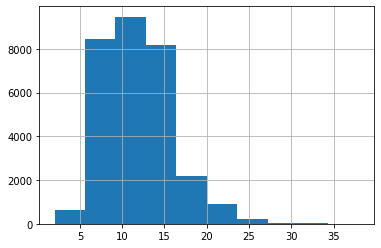

In [0]:
# Clean captions
# train_img_captions = dict(map(lambda x: (x[0], [*map(clean, x[1])]), train_img_captions.items()))
# valid_img_captions = dict(map(lambda x: (x[0], [*map(clean, x[1])]), valid_img_captions.items()))
# test_img_captions = dict(map(lambda x: (x[0], [*map(clean, x[1])]), test_img_captions.items()))

# Get the length of the longest caption
all_train_captions = [*functools.reduce(lambda x, y: x + y, train_img_captions.values())]
print('Max train image caption length:', max(map(len, map(str.split, all_train_captions))))
plt.hist([*map(len, map(str.split, all_train_captions))])
plt.grid()
plt.show()

In [0]:
MIN_COUNT = 5
MAX_LEN = 25
all_train_captions = [*functools.reduce(lambda x, y: x + y, train_img_captions.values())]
EN = Field(init_token=SOS_TOKEN,
           eos_token=EOS_TOKEN,
           fix_length=MAX_LEN,
           lower=True,
           tokenize='spacy',
           tokenizer_language='en',
           include_lengths=True)
examples = [Example.fromlist(data=[caption], fields=[('caption', EN)])
            for caption in tqdm.tqdm(all_train_captions)]
captions_data = Dataset(examples, fields={'caption': EN})
EN.build_vocab(captions_data,
               min_freq=MIN_COUNT,
               specials=[SOS_TOKEN, UNK_TOKEN, EOS_TOKEN, PAD_TOKEN])
print(f'Length of vocabulary: {len(EN.vocab):,}')

100%|██████████| 30000/30000 [00:02<00:00, 14383.61it/s]

Length of vocabulary: 2,548


In [0]:
def caption_transform(caption):
    if isinstance(caption, str):
        return EN.process([EN.preprocess(caption)])
    elif isinstance(caption, list):
        return EN.process([*map(EN.preprocess, caption)])
    else:
        raise NotImplementedError

## 3.2. Image data

In [0]:
IMG_SHAPE = (256, 256)

img_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: x / 255.),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])])

## 3.3. Build datasets

In [0]:
class ImageCaptionDataset(torch.utils.data.Dataset):
    
    def __init__(self, data_path, img_captions, split_set, img_transform, caption_transform, img_shape=(256, 256)):
        assert split_set in {'TRAIN', 'VALID', 'TEST'}
        self.data_path = data_path
        self.img_captions = img_captions
        self.split_set = split_set
        self.img_transform = img_transform
        self.caption_transform = caption_transform
        self.img_shape = img_shape
        self.ids = list(sorted(self.img_captions.keys()))
    
    def __getitem__(self, index):
        img_id = self.ids[index]

        img = Image.open(os.path.join(self.data_path, img_id)).convert('RGB')
        img = self.img_transform(img.resize(self.img_shape))

        targets = self.img_captions[img_id]
        targets = self.caption_transform(targets)
        
        idx = np.random.randint(len(targets))
        target = (targets[0][:, idx], targets[1][idx])
        
        if self.split_set is 'TRAIN':
            return img, target
        else:
            return img, target, targets
    
    def __len__(self):
        return len(self.ids)

In [0]:
train_dataset = ImageCaptionDataset(data_path='./data/Flicker8k_Dataset/',
                                    img_captions=train_img_captions,
                                    split_set='TRAIN',
                                    img_transform=img_transform,
                                    caption_transform=caption_transform)
valid_dataset = ImageCaptionDataset(data_path='./data/Flicker8k_Dataset/',
                                    img_captions=valid_img_captions,
                                    split_set='VALID',
                                    img_transform=img_transform,
                                    caption_transform=caption_transform)

# 4. Modeling

## 4.1. Generate image features - ResNet Encoder

In [0]:
class ResNetEncoder(nn.Module):
    
    def __init__(self, hidden_size=2048):
        super(ResNetEncoder, self).__init__()
        resnet = torchvision.models.wide_resnet101_2(pretrained=True)
        modules = list(resnet.children())[:-2]
        self.hidden_size = hidden_size
        self.resnet = nn.Sequential(*modules)
        
    def fine_tuning_resnet(self, fine_tune):
        for p in self.resnet.parameters():
            p.requires_grad = False
        for c in list(self.resnet.children())[5:]:
            for p in c.parameters():
                p.requires_grad = fine_tune
        
    def forward(self, images):
        """
        :param
            images: Tensor[batch_size, 3, img_size, img_size]
        :return
            out: Tensor[batch_size, 8, 8, hidden_size]
        """
        out = self.resnet(images)
        out = out.permute(0, 2, 3, 1)
        return out

In [0]:
def test_encoder():
    encoder = ResNetEncoder()
    latent = encoder(torch.rand((10, 3, 256, 256)))
    assert latent.size() == torch.Size([10, 8, 8, 2048]), latent.size() 
    
test_encoder()

## 4.2. Badhanau Attention

In [0]:
class BahdanauAttention(nn.Module):
    
    def __init__(self, enc_hidden_size, dec_hidden_size, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.W1 = nn.Linear(enc_hidden_size, hidden_size)
        self.W2 = nn.Linear(dec_hidden_size, hidden_size)
        self.V = nn.Linear(hidden_size, 1)

    def forward(self, features, h_state):
        """
        :param
            features:  Tensor[batch_size, num_pixels, enc_hidden_size]
            h_state: Tensor[batch_size, dec_hidden_size]
        :return
            context_vector: Tensor[batch_size, enc_hidden_size]
            attention_weights: Tensor[batch_size, num_pixels]
        """
        h_state = h_state.unsqueeze(1) # [batch_size, 1, dec_hidden_size]
        score = F.elu(self.W1(features) + self.W2(h_state)) # [batch_size, num_pixels, hidden_size]
        attention_weights = F.softmax(self.V(score), dim=1) # [batch_size, num_pixels, 1]
        context_vector = attention_weights * features # [batch_size, num_pixels, enc_hidden_size]
        context_vector = torch.sum(context_vector, dim=1) # [batch_size, enc_hidden_size]
        return context_vector, attention_weights.squeeze(2)

In [0]:
def test_attention():
    attention = BahdanauAttention(enc_hidden_size=2048, dec_hidden_size=512, hidden_size=512)
    context_vector, attention_weights = attention(torch.rand((10, 8*8, 2048)), torch.rand((10, 512)))
    assert context_vector.size() == torch.Size([10, 2048])
    assert attention_weights.size() == torch.Size([10, 8*8])
    
test_attention()

## 4.3. Generate captions - LSTM Decoder

In [0]:
class DecoderWithBahdanauAttention(nn.Module):
    
    def __init__(self, enc_hidden_size, attn_hidden_size, hidden_size, embedding_size, vocab_size, dropout):
        super(DecoderWithBahdanauAttention, self).__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.dropout = dropout
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.dropout = nn.Dropout(p=dropout)
        self.lstm = nn.LSTM(embedding_size + enc_hidden_size, hidden_size)
        self.attention = BahdanauAttention(enc_hidden_size, hidden_size, attn_hidden_size)
        self.f_beta = nn.Linear(hidden_size, enc_hidden_size)
        self.fc = nn.Linear(hidden_size, vocab_size)
        
    def load_pretrained_embeddings(self, embeddings):
        self.embedding.weight = nn.Parameter(embeddings)
        
    def fine_tuning_embeddings(self, fine_tune=False):
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune
        
    def forward(self, input_word_index, h_state, c_state, enc_outputs):
        """
        :param
            input_word_index: Tensor[batch_size,]
            h_state: Tensor[1, batch_size, hidden_size]
            c_state: Tensor[1, batch_size, hidden_size]
            enc_outputs: Tensor[batch_size, num_pixels, enc_hidden_size]
        :return
            logit: Tensor[batch_size, vocab_size]
            h_state: Tensor[1, batch_size, hidden_size]
            c_state: Tensor[1, batch_size, hidden_size]
            attention_weights: Tensor[batch_size, num_pixels]
        """
        embedded = self.embedding(input_word_index)  # [batch_size, embedding_size]
        context_vector, attention_weights = self.attention(enc_outputs, h_state.squeeze(0))
        # context_vector: Tensor[batch_size, enc_hidden_size]
        # attention_weights: Tensor[batch_size, num_pixels]
        
        gate = torch.sigmoid(self.f_beta(h_state))  # [1, batch_size, enc_hidden_size], Gating scalar
        context_vector = gate.squeeze(0) * context_vector # [batch_size, enc_hidden_size]
        
        x = torch.cat((embedded, context_vector), dim=1) # [batch_size, embedding_size + enc_hidden_size]
        output, (h_state, c_state) = self.lstm(x.unsqueeze(0), (h_state, c_state))
        # output: [1, batch_size, hidden_size]
        # h_state: [1, batch_size, hidden_size]
        # c_state: [1, batch_size, hidden_size]
        
        logit = self.fc(self.dropout(output)) # [1, batch_size, vocab_size]
        logit = logit.squeeze(0) # [batch_size, vocab_size]
        return logit, h_state, c_state, attention_weights

In [0]:
def test_decoder():
    decoder = DecoderWithBahdanauAttention(enc_hidden_size=2048,
                                           attn_hidden_size=512,
                                           hidden_size=512,
                                           embedding_size=512,
                                           vocab_size=1000,
                                           dropout=0.5)
    logit, h_state, c_state, attention_weights = decoder(torch.randint(low=0, high=1000, size=(10,)),
                                                         torch.rand((1, 10, 512)),
                                                         torch.rand((1, 10, 512)),
                                                         torch.rand((10, 14*14, 2048)))
    assert logit.size() == torch.Size([10, 1000])
    assert h_state.size() == torch.Size([1, 10, 512])
    assert c_state.size() == torch.Size([1, 10, 512])
    assert attention_weights.size() == torch.Size([10, 14*14])
    
test_decoder()

## 4.4. Putting all together - AutoEncoder

In [0]:
class AutoEncoder(nn.Module):
    
    def __init__(self, encoder, decoder, device):
        super(AutoEncoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.init_h0 = nn.Linear(encoder.hidden_size, decoder.hidden_size)
        self.init_c0 = nn.Linear(encoder.hidden_size, decoder.hidden_size)
        self.device = device
        
    def forward(self, images, target_sequences, sequence_lengths, tf_ratio):
        """
        :param
            images: Tensor[batch_size, 3, img_size, img_size]
            target_sequences: Tensor[batch_size, seq_len]
            sequence_lengths: Tensor[batch_size,]
            tf_ratio: float
        :return
            logits: Tensor[max(decode_lengths), batch_size, vocab_size]
            logits: Tensor[batch_size, max(decode_lengths), num_pixels]
            sorted_target_sequences: Tensor[seq_len, batch_size]
            sorted_decode_lengths: list[seq_len]
            sorted_indices: list[batch_size]
        """
        batch_size = images.size(0)
        
        # Encoding
        image_features = self.encoder(images) # [batch_size, 14, 14, hidden_size]
        image_features = image_features.view(batch_size, -1, self.encoder.hidden_size) # [batch_size, num_pixels, enc_hidden_size]
        num_pixels = image_features.size(1)
        
        # Sort the batch by decreasing lengths
        sorted_sequence_lengths, sorted_indices = torch.sort(sequence_lengths, dim=0, descending=True)
        sorted_image_features = image_features[sorted_indices] # [batch_size, num_pixels, enc_hidden_size]
        sorted_target_sequences = target_sequences[sorted_indices] # [seq_len, batch_size]
        
        # Init hidden and memory states
        mean_image_features = sorted_image_features.mean(dim=1) # [batch_size, enc_hidden_size]
        h_state, c_state = self.init_h0(mean_image_features), self.init_c0(mean_image_features) # [batch_size, dec_hidden_size]
        h_state, c_state = h_state.unsqueeze(0), c_state.unsqueeze(0) # [1, batch_size, dec_hidden_size]
        
        # We won't decode at the <eos> position, since we've finished generating as soon as we generate <eos>
        # So, decoding lengths are actual lengths - 1
        sorted_decode_lengths = (sorted_sequence_lengths - 1).tolist()
        
        # Decoding
        logits = torch.zeros(max(sorted_decode_lengths), batch_size, self.decoder.vocab_size).to(self.device)
        alphas = torch.zeros(batch_size, max(sorted_decode_lengths), num_pixels).to(self.device)
        last = None
        for t in range(max(sorted_decode_lengths)):
            batch_size_t = sum([l > t for l in sorted_decode_lengths])
            
            if last is not None:
                if random.random() < tf_ratio:
                    in_ = last[:batch_size_t]
                else:
                    in_ = sorted_target_sequences[:batch_size_t, t]
            else:
                in_ = sorted_target_sequences[:batch_size_t, t]
            
            logit, h_state, c_state, attention_weights = self.decoder(in_,
                                                                      h_state[:, :batch_size_t, :],
                                                                      c_state[:, :batch_size_t, :],
                                                                      sorted_image_features[:batch_size_t, :, :])
            logits[t, :batch_size_t, :] = logit
            alphas[:batch_size_t, t, :] = attention_weights
            last = torch.argmax(F.softmax(logit, dim=1), dim=1) # [batch_size,]
        
        return logits, alphas, sorted_target_sequences, sorted_decode_lengths, sorted_indices

In [0]:
def test_autoencoder():
    encoder = ResNetEncoder()
    decoder = DecoderWithBahdanauAttention(enc_hidden_size=2048,
                                           attn_hidden_size=512,
                                           hidden_size=512,
                                           embedding_size=512,
                                           vocab_size=1000,
                                           dropout=0.5)
    autoencoder = AutoEncoder(encoder=encoder, decoder=decoder, device='cpu')
    logits, alphas, sorted_target_sequences, sorted_decode_lengths, sorted_indices = \
        autoencoder(torch.rand((10, 3, 256, 256)),
                    torch.randint(low=0, high=1000, size=(10, 25)),
                    torch.randint(low=5, high=26, size=(10,)), 0.5)
    assert logits.size() == torch.Size([max(sorted_decode_lengths), 10, 1000])
    assert alphas.size() == torch.Size([10, max(sorted_decode_lengths), 8*8])
    assert len(sorted_decode_lengths) == 10
    assert sorted_target_sequences.size() == torch.Size([10, 25])
    assert len(sorted_indices) == 10
    
test_autoencoder()

# 5. Training

## 5.1. Training routines

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def init_embeddings(embeddings):
    bias = np.sqrt(3.0 / embeddings.size(1))
    torch.nn.init.uniform_(embeddings, -bias, bias)

def load_embeddings(nlp, field):
    embeddings = torch.FloatTensor(len(field.vocab), 300)
    init_embeddings(embeddings)
    for token, index in tqdm.tqdm(field.vocab.stoi.items()):
        token = nlp(token)
        if token.has_vector:
            embeddings[index] = torch.tensor(token.vector, dtype=torch.float32)
    return embeddings

def clip_gradient(optimizer, grad_clip):
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

def save_checkpoint(model, optimizer, data_name, epoch, last_improv, bleu4, is_best):
    state = {
        'epoch': epoch,
        'bleu-4': bleu4,
        'last_improv': last_improv,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    if not os.path.exists('./checkpoint'):
        !mkdir ./checkpoint
    torch.save(state, './checkpoint/' + data_name + '.pt')
    if is_best:
        torch.save(state, './checkpoint/' + 'BEST_' + data_name + '.pt')

        
class AvgMeter(object):

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def adjust_lr(optimizer, shrink_factor):
    print("\nDecaying learning rate.")
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * shrink_factor
    print("The new learning rate is %f\n" % (optimizer.param_groups[0]['lr'],))
    
def accuracy(outputs, target_sequences, k=5):
    batch_size = outputs.size(1)
    _, indices = outputs.topk(k, dim=1, largest=True, sorted=True)
    correct = indices.eq(target_sequences.view(-1, 1).expand_as(indices))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)

In [0]:
def train_step(model, optimizer, criterion, loader, epoch, grad_clip, alpha_c, tf_ratio, device):
    loss_tracker, acc_tracker = AvgMeter(), AvgMeter()
    model.train()
    pbar = tqdm.tqdm(enumerate(loader), total=len(loader))
    for i, (images, (target_sequences, sequence_lengths)) in pbar:
        images = images.to(device)
        target_sequences = target_sequences.to(device)
        sequence_lengths = sequence_lengths.to(device)
        # Forward prop.
        logits, alphas, sorted_target_sequences, sorted_decode_lengths, sorted_indices = model(images, target_sequences, sequence_lengths, tf_ratio)
        # Since we decoded starting with <sos>, the targets are all words after <sos>, up to <eos>
        sorted_target_sequences = sorted_target_sequences[:, 1:]
        # Remove paddings
        logits = pack_padded_sequence(logits, sorted_decode_lengths).data
        sorted_target_sequences = pack_padded_sequence(sorted_target_sequences, sorted_decode_lengths, batch_first=True).data
        # Calculate loss
        loss = criterion(logits, sorted_target_sequences)
        # Add doubly stochastic attention regularization
        loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()
        # Back prop.
        optimizer.zero_grad()
        loss.backward()
        # Clip gradients
        if grad_clip is not None:
            clip_gradient(optimizer, grad_clip)
        # Update weights
        optimizer.step()
        # Track metrics
        loss_tracker.update(loss.item(), sum(sorted_decode_lengths))
        acc_tracker.update(accuracy(logits, sorted_target_sequences, 5), sum(sorted_decode_lengths))
        # Update progressbar description
        pbar.set_description(f'Epoch: {epoch + 1:03d} - loss: {loss_tracker.avg:.3f} - acc: {acc_tracker.avg:.3f}%')
    return loss_tracker.avg, acc_tracker.avg

In [0]:
def validate(model, criterion, loader, field, epoch, alpha_c, device):
    references, hypotheses = [], []
    loss_tracker, acc_tracker = AvgMeter(), AvgMeter()
    model.eval()
    with torch.no_grad():
        pbar = tqdm.tqdm(enumerate(loader), total=len(loader))
        for i, (images, (target_sequences, sequence_lengths), (all_target_sequences, all_sequence_lengths)) in pbar:
            images = images.to(device)
            target_sequences = target_sequences.to(device)
            sequence_lengths = sequence_lengths.to(device)
            all_target_sequences = all_target_sequences.to(device)
            all_sequence_lengths = all_sequence_lengths.to(device)
            # Forward prop.
            logits, alphas, sorted_target_sequences, sorted_decode_lengths, sorted_indices = model(images, target_sequences, sequence_lengths, 0)
            # Since we decoded starting with <sos>, the targets are all words after <sos>, up to <eos>
            sorted_target_sequences = sorted_target_sequences[:, 1:]
            # Remove paddings
            logits_copy = logits.clone()
            logits = pack_padded_sequence(logits, sorted_decode_lengths).data
            sorted_target_sequences = pack_padded_sequence(sorted_target_sequences, sorted_decode_lengths, batch_first=True).data
            # Calculate loss
            loss = criterion(logits, sorted_target_sequences)
            # Add doubly stochastic attention regularization
            loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()
            # Track metrics
            loss_tracker.update(loss.item(), sum(sorted_decode_lengths))
            acc_tracker.update(accuracy(logits, sorted_target_sequences, 5), sum(sorted_decode_lengths))
            # Update references
            all_sorted_target_sequences = all_target_sequences[sorted_indices] # Because images were sorted in the decoder
            for j in range(all_sorted_target_sequences.size(0)):
                img_caps = all_sorted_target_sequences[j].t().tolist()
                # Remove <sos> and <pad> tokens
                img_caps = [*map(lambda c: [field.vocab.itos[w] for w in c
                                            if w not in (field.vocab.stoi[field.init_token],
                                                         field.vocab.stoi[field.pad_token])], img_caps)]
                references.append(img_caps)
            # Update hypotheses
            _, preds = torch.max(logits_copy, dim=2)
            preds, temp_preds = preds.t().tolist(), []
            for j, p in enumerate(preds):
                temp_preds.append([*map(lambda w: field.vocab.itos[w], preds[j][:sorted_decode_lengths[j]])]) # Remove padding
            hypotheses.extend(temp_preds)
            # Update progressbar description
            pbar.set_description(f'Epoch: {epoch + 1:03d} - val_loss: {loss_tracker.avg:.3f} - val_acc: {acc_tracker.avg:.3f}%')
        # Calculate BLEU-4 score
        bleu4 = bleu_score(hypotheses, references, max_n=4, weights=[0.25, 0.25, 0.25, 0.25])
    return loss_tracker.avg, acc_tracker.avg, bleu4

In [0]:
def train(model, optimizer, criterion, train_loader, valid_loader, field, alpha_c, start_epoch, n_epochs, grad_clip, tf_ratio, device, model_name, last_improv):
    history, best_bleu = {
        'acc': [],
        'loss': [],
        'val_acc': [],
        'val_loss': [],
        'bleu4': []
    }, 0.
    for epoch in range(start_epoch, n_epochs):
        # Stop training if no improvment since last 4 epochs
        if last_improv == 4:
            print('Training Finished - The model has stopped improving since last 4 epochs')
            break
        # Decay LR if no improvment
        if last_improv > 0:
            adjust_lr(optimizer, 0.8)
        # Train step
        loss, acc = train_step(model=model, optimizer=optimizer, criterion=criterion,
                               loader=train_loader, epoch=epoch, grad_clip=grad_clip,
                               alpha_c=alpha_c, tf_ratio=tf_ratio, device=device)
        # Validation step
        val_loss, val_acc, bleu4 = validate(model=model, criterion=criterion, loader=valid_loader,
                                            field=field, epoch=epoch, alpha_c=alpha_c, device=device)
        # Update history dict
        history['acc'].append(acc)
        history['loss'].append(loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)
        history['bleu4'].append(bleu4)
        # Print BLEU score
        text = f'BLEU-4: {bleu4*100:.3f}%'
        if best_bleu > bleu4:
            last_improv += 1
            text += f' - Last improvement since {last_improv} epoch(s)'
        else:
            best_bleu, last_improv = bleu4, 0
        print(text)
        # Save checkpoint
        save_checkpoint(model=model, optimizer=optimizer, data_name=model_name, epoch=epoch, last_improv=last_improv, bleu4=bleu4, is_best=bleu4 >= best_bleu)
    return history

## 5.2. Training models

In [0]:
MODEL_NAME = 'Flickr_8k'
ENCODER_HIDDEN_SIZE = 2048
ATTENTION_SIZE = 512
DECODER_HIDDEN_SIZE = 512
EMBEDDING_SIZE = 300
DROPOUT = 0.

In [0]:
n_epochs = 10
batch_size = 32
lr = 3e-5
grad_clip = 5.
alpha_c = 1.
tf_ratio = 0.

In [0]:
spacy_nlp = spacy.load('en_core_web_lg')
embeddings = load_embeddings(nlp=spacy_nlp, field=EN)

100%|██████████| 2548/2548 [00:22<00:00, 114.39it/s]


In [0]:
encoder = ResNetEncoder()
encoder.fine_tuning_resnet(fine_tune=True)
decoder = DecoderWithBahdanauAttention(enc_hidden_size=ENCODER_HIDDEN_SIZE,
                                       attn_hidden_size=ATTENTION_SIZE,
                                       hidden_size=DECODER_HIDDEN_SIZE,
                                       embedding_size=EMBEDDING_SIZE,
                                       vocab_size=len(EN.vocab),
                                       dropout=DROPOUT)
decoder.load_pretrained_embeddings(embeddings)
decoder.fine_tuning_embeddings(fine_tune=True)
autoencoder = AutoEncoder(encoder=encoder, decoder=decoder, device=DEVICE).to(DEVICE)
optimizer = optim.RMSprop(params=autoencoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
print(f'Number of parameters of the model: {count_parameters(autoencoder):,}')

Number of parameters of the model: 136,587,749


In [0]:
# Define data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           num_workers=N_WORKERS,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           num_workers=N_WORKERS,
                                           batch_size=batch_size,
                                           shuffle=True, 
                                           pin_memory=True)

In [0]:
history = train(model=autoencoder,
                optimizer=optimizer,
                criterion=criterion,
                train_loader=train_loader,
                valid_loader=valid_loader,
                field=EN,
                alpha_c=alpha_c,
                start_epoch=0,
                n_epochs=n_epochs,
                grad_clip=grad_clip,
                tf_ratio=tf_ratio,
                device=DEVICE,
                model_name=MODEL_NAME,
                last_improv=0)

Epoch: 001 - val_loss: 5.280 - val_acc: 6.652%: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]


BLEU-4: 4.154%


Epoch: 002 - val_loss: 5.095 - val_acc: 6.963%: 100%|██████████| 32/32 [00:11<00:00,  2.67it/s]


BLEU-4: 4.897%


Epoch: 003 - val_loss: 4.934 - val_acc: 7.446%: 100%|██████████| 32/32 [00:12<00:00,  2.65it/s]


BLEU-4: 5.187%


Epoch: 004 - val_loss: 4.785 - val_acc: 7.754%: 100%|██████████| 32/32 [00:11<00:00,  2.71it/s]


BLEU-4: 6.327%


Epoch: 005 - val_loss: 4.696 - val_acc: 8.009%: 100%|██████████| 32/32 [00:11<00:00,  2.68it/s]


BLEU-4: 6.955%


Epoch: 006 - val_loss: 4.614 - val_acc: 8.251%: 100%|██████████| 32/32 [00:11<00:00,  2.67it/s]


BLEU-4: 7.721%


Epoch: 007 - val_loss: 4.543 - val_acc: 8.473%: 100%|██████████| 32/32 [00:11<00:00,  2.73it/s]


BLEU-4: 8.431%


Epoch: 008 - val_loss: 4.474 - val_acc: 8.700%: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]


BLEU-4: 8.498%


Epoch: 009 - val_loss: 4.415 - val_acc: 8.689%: 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]


BLEU-4: 10.503%


Epoch: 010 - val_loss: 4.392 - val_acc: 8.940%: 100%|██████████| 32/32 [00:11<00:00,  2.67it/s]


BLEU-4: 10.417% - Last improvement since 1 epoch(s)


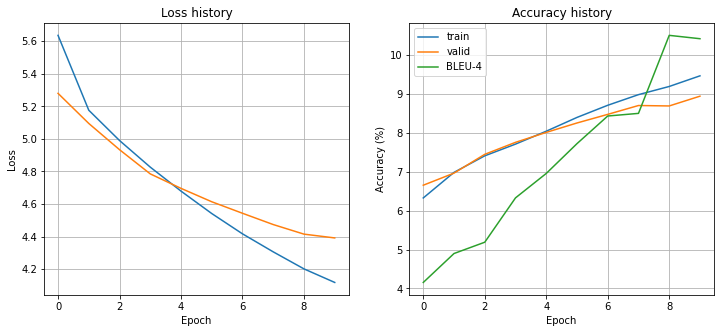

In [0]:
_, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(history['loss'], label='train')
axes[0].plot(history['val_loss'], label='valid')
axes[0].set_title('Loss history')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[1].plot(history['acc'], label='train')
axes[1].plot(history['val_acc'], label='valid')
axes[1].plot(np.array(history['bleu4']) * 100., label='BLEU-4')
axes[1].set_title('Accuracy history')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].grid(True)
plt.legend()
plt.show()

# 6. Evaluation - BLEU Score

In [0]:
autoencoder.load_state_dict(torch.load('./checkpoint/BEST_Flickr_8k.pt').get('model'))

<All keys matched successfully>

In [0]:
test_dataset = ImageCaptionDataset(data_path='./data/Flicker8k_Dataset/',
                                   img_captions=test_img_captions,
                                   split_set='TEST',
                                   img_transform=img_transform,
                                   caption_transform=caption_transform)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          num_workers=N_WORKERS,
                                          batch_size=1,
                                          shuffle=True, 
                                          pin_memory=True)

In [0]:
class BeamNode:
    __index = 0

    def __init__(self, ):

In [0]:
def evaluate(model, loader, beam_size, field, max_len, device):
    references, hypotheses = [], []
    model.eval()
    with torch.no_grad():
        pbar = tqdm.tqdm(enumerate(loader), total=len(loader))
        for i, (images, (target_sequences, sequence_lengths), (all_target_sequences, all_sequence_lengths)) in pbar:
            images = images.to(device)
            target_sequences = target_sequences.to(device)
            sequence_lengths = sequence_lengths.to(device)
            all_target_sequences = all_target_sequences.to(device)
            all_sequence_lengths = all_sequence_lengths.to(device)
            
            k = beam_size
            
            # Encoding
            image_features = model.encoder(images) # [1, 14, 14, hidden_size]
            image_features = image_features.view(1, -1, model.encoder.hidden_size) # [1, num_pixels, enc_hidden_size]
            
            # Init hidden and memory states
            mean_image_features = image_features.mean(dim=1) # [1, enc_hidden_size]
            h_state, c_state = model.init_h0(mean_image_features), model.init_c0(mean_image_features) # [1, dec_hidden_size]

            # Decoding
            step = 1
            while True:
                embedded = model.decoder.embedding(topk_prev_tokens.squeeze(1))  # [k, embedding_size]
                context_vector, _ = model.decoder.attention(image_features, h_state)
                # context_vector: Tensor[k, enc_hidden_size]
                # _: Tensor[k, num_pixels]
                gate = torch.sigmoid(model.decoder.f_beta(h_state))  # [k, enc_hidden_size], Gating scalar
                context_vector = gate * context_vector # [k, enc_hidden_size]
                x = torch.cat((embedded, context_vector), dim=1) # [k, embedding_size + enc_hidden_size]
                h_state, c_state = h_state.unsqueeze(0).contiguous(), c_state.unsqueeze(0).contiguous()
                output, (h_state, c_state) = model.decoder.lstm(x.unsqueeze(0), (h_state, c_state))
                # output: [1, k, hidden_size]
                # h_state: [1, k, hidden_size]
                # c_state: [1, k, hidden_size]
                logit = model.decoder.fc(output) # [1, k, vocab_size]
                logp = F.log_softmax(logit.squeeze(0), dim=1) # [k, vocab_size]

                topk_logp = torch.topk(logp, k, dim=1) # [k, k]

# 7. Inference - Beam Search